># 【問題1】仮定関数  
以下の数式で表される線形回帰の仮定関数を実装してください。メソッドの雛形を用意してあります。  

$
h_\theta(x) =  \theta_0 x_0 + \theta_1 x_1 + ... + \theta_j x_j + ... +\theta_n x_n.   (x_0 = 1)\\
$

x: 特徴量ベクトル

θ : パラメータベクトル

n : 特徴量の数


$x_j$: j番目の特徴量

$θ_j$: j番目のパラメータ（重み）

特徴量の数nは任意の値に対応できる実装にしてください。

なお、ベクトル形式で表すと以下のようになります。

$
h_\theta(x) = \theta^T \cdot x.
$


In [644]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
warnings.simplefilter("ignore")

># 【問題2】最急降下法  
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fitメソッドから呼び出すようにしてください。

$
\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]
$

$α$:学習率

$i$:サンプルのインデックス

$j$:特徴量のインデックス

In [720]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装
    
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    
    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録
    """
    
    def __init__(self, num_iter=3000, lr=0.1, no_bias=False, verbose=True):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
    def fit(self, X, y, X_val=np.empty(1), y_val=np.empty(1)):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.y = y
        self.y_val = y_val
        if self.no_bias == False:
            self.X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)  #バイアス項を結合
            self.X_val = np.concatenate([np.ones(X_val.shape[0])[:,np.newaxis],X_val],axis=1)  #バイアス項を結合
        else:
            self.X = X
            self.X_val = X_val
            
        
        
        if (len(X_val) != 1) & (len(y_val) != 1):  #検証データが入力された場合
            error = self._gradient_descent(self.X)
            self.loss[0] = loss_func(self.predict(self.X),y)
            self.val_loss[0] = loss_func(self.predict(self.X_val),y_val)  #下に移動するべき
            for i in range(self.iter-1):  #iter-1回_gradient_descentを実行する
                error = self._gradient_descent(self.X,error)
                self.loss[i+1] = loss_func(self.predict(self.X),y)#(self.predict(self.X),y)
                self.val_loss[i+1] = loss_func(self.predict(self.X_val),self.y_val)  #下に移動するべき
                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("theta:{}".format(self.theta))
                    print("損失:{}".format(self.val_loss[i+1]))
                    print("精度（平均2乗誤差）:{}\n".format(MSE(self.predict(self.X_val),self.y_val)))
            
                    
        
        else:  #検証データが入力されない場合
            error = self._gradient_descent(X)
            self.loss[0] = loss_func(error,X.shape[0])
            for i in range(self.iter-1):
                error = self._gradient_descent(X,error)
                self.loss[i+1] = loss_func(error,X.shape[0])
                #self.val_loss[i+1] = loss_func(error,shape[0])
                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("theta:\n{}".format(self.theta))
    
    def _gradient_descent(self, X,error=np.empty(1)):
        """
        _linear_hypothesisを用いて仮定関数を作り、
        誤差を求めて_gradient_descentを再帰的に呼び出す
        """
        if error.shape == (1,):  #errorが渡されていない時
            if self.no_bias == False:  #バイアス項があればx_0を１で初期化してから_linear_hypothesisを呼び出す
                #X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)  #バイアス項を結合
                self.y = self.y.reshape(self.y.shape[0],1)  #_linear_hypothesisの返り値（行列）にサイズを合わせるためreshapeする
                #thetaとerrorの初期化
                self.theta = np.ones(X.shape[1]).reshape(1,-1)
                error = (self._linear_hypothesis(X) - self.y).flatten()
                
        else:  #errorが渡されている時
            if self.no_bias == False:  #バイアス項があればx_0を１で初期化してから_linear_hypothesisを呼び出す
                #X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)  #バイアス項を結合
                self.y = self.y.reshape(self.y.shape[0],1)  #_linear_hypothesisの返り値（行列）にサイズを合わせるためreshapeする
                a = self._linear_hypothesis(X)
                error = (a - self.y).flatten()
            else:  #バイアス項がない場合はerrorを求めるだけ
                self.y = self.y.reshape(self.y.shape[0],1)  #_linear_hypothesisの返り値（行列）にサイズを合わせるためreshapeする
                error = (self._linear_hypothesis(X) - self.y).flatten()
        #次に使うthetaを計算
        self.theta = self.theta - (self.lr/X.shape[0])*error@X
        #print(error)
        return error
        """
        if self.theta >= next_theta:  #停止条件(今は適当)
            pass#return _linear_hypothesis(X)
        else:  #満たさなければ継続
            self.theta = next_theta
            return _gradient_descent(X,_linear_hypothesis(X) - self.y)
        """
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
        線形の仮定関数による推定結果
        """
        if X.shape[1] != self.theta.T.shape[0]:
            X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)
        return np.dot(X,self.theta.T)
    
    def predict(self, X):
        """
        線形回帰を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        return self._linear_hypothesis(X)

># 【問題3】推定
推定する仕組みを実装してください。ScratchLinearRegressionクラスの雛形に含まれるpredictメソッドに書き加えてください。  
仮定関数$h_\theta(x)$の出力が推定結果です。



># 【問題4】平均二乗誤差  
線形回帰の指標値として用いられる平均二乗誤差（mean square error, MSE）の関数を作成してください。
平均二乗誤差関数は回帰問題全般で使える関数のため、ScratchLinearRegressionクラスのメソッドではなく、別の関数として作成してください。雛形を用意してあります。  
平均二乗誤差は以下の数式で表されます。 

>$
L(\theta)=  \frac{1 }{ m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$  

>$m$:入力されるデータの数  
$h_\theta()$:仮定関数  
$x^{(i)}$:i番目のサンプルの正解値  
$y^{(i)}$:i番目のサンプルの正解値  
なお、最急降下法のための目的関数（損失関数）としては、これを2で割ったものを使用します。（問題5, 9）

In [583]:
#平均2乗誤差
def MSE(y_pred,y):
    """
    平均二乗誤差の計算

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    mse = ((y_pred - y)**2).mean()
    return mse

# 【問題5】目的関数
以下の数式で表される線形回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。  
目的関数（損失関数） $J(\theta)$ は次の式です。  

$
J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$

$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数

$x^{(i)}$ : i番目のサンプルの特徴量ベクトル

$y^{(i)}$ : i番目のサンプルの正解値



In [544]:
#損失関数
def loss_func(y_pred,y):
    return MSE(y_pred,y)/2

# 【問題6】学習と推定
機械学習スクラッチ入門のSprintで用意したHouse Pricesコンペティションのデータに対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。



In [742]:
df = pd.read_csv("../week3/train.csv")
features_list = ["OverallQual"]#["OverallQual"]#,"GrLivArea","GarageCars","GarageArea","TotalBsmtSF",\
                 #"1stFlrSF","FullBath","TotRmsAbvGrd","YearBuilt","YearRemodAdd"]
df_x = df[features_list]
df_y = df.SalePrice

尖度：6.536281860064529
歪度：1.8828757597682129


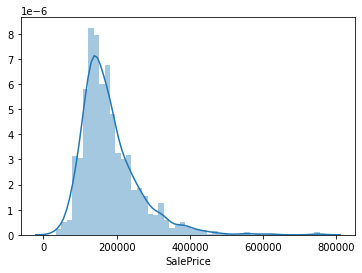

In [743]:
print("尖度：{}".format(df_y.kurt()))
print("歪度：{}".format(df_y.skew()))
sns.distplot(df_y)
plt.show()

尖度：0.8095319958036296
歪度：0.12133506220520406


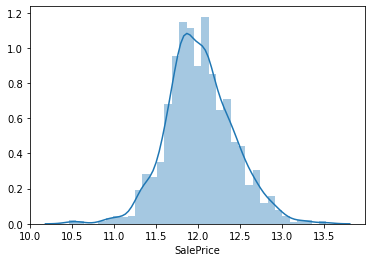

In [744]:
#対数変換を行い、正規分布に近づける

df_x = df_x.apply(np.log)
df_y = df_y.apply(np.log)
print("尖度：{}".format(df_y.kurt()))
print("歪度：{}".format(df_y.skew()))
sns.distplot(df_y)
plt.show()

In [745]:
x_train,x_test,y_train,y_test = \
train_test_split(np.array(df_x),np.array(df_y),train_size = 0.8)
lr = ScratchLinearRegression()
lr.fit(x_train,y_train,x_test,y_test)

theta:[[2.46275054 3.59740477]]
損失:5.362491206533911
精度（平均2乗誤差）:10.724982413067822

theta:[[2.77829251 4.14521542]]
損失:2.2251507424588732
精度（平均2乗誤差）:4.4503014849177465

theta:[[2.96477219 4.4599885 ]]
損失:1.1795275772789005
精度（平均2乗誤差）:2.359055154557801

theta:[[3.07657558 4.63993772]]
損失:0.8318077148415347
精度（平均2乗誤差）:1.6636154296830694

theta:[[3.1451684  4.74188594]]
損失:0.7163889100741611
精度（平均2乗誤差）:1.4327778201483221

theta:[[3.18875556 4.79870876]]
損失:0.6779711915040739
精度（平均2乗誤差）:1.3559423830081478

theta:[[3.21786978 4.82942677]]
損失:0.6648905066998375
精度（平均2乗誤差）:1.329781013399675

theta:[[3.2386049  4.84504461]]
損失:0.660038445366212
精度（平均2乗誤差）:1.320076890732424

theta:[[3.25448659 4.85192912]]
損失:0.6577954898923798
精度（平均2乗誤差）:1.3155909797847596

theta:[[3.26755469 4.85376395]]
損失:0.6563426640974566
精度（平均2乗誤差）:1.3126853281949131

theta:[[3.2789894  4.85268029]]
損失:0.6551070122521888
精度（平均2乗誤差）:1.3102140245043776

theta:[[3.28947352 4.84991118]]
損失:0.6539175300224771
精度（平均2乗誤差）:1.307

theta:[[4.29660846 4.29637783]]
損失:0.5276919963077534
精度（平均2乗誤差）:1.0553839926155069

theta:[[4.30435026 4.2920908 ]]
損失:0.5267789980180073
精度（平均2乗誤差）:1.0535579960360146

theta:[[4.31208095 4.28780992]]
損失:0.5258682209167469
精度（平均2乗誤差）:1.0517364418334938

theta:[[4.31980056 4.28353518]]
損失:0.5249596592043784
精度（平均2乗誤差）:1.0499193184087567

theta:[[4.32750908 4.27926658]]
損失:0.524053307097123
精度（平均2乗誤差）:1.048106614194246

theta:[[4.33520655 4.2750041 ]]
損失:0.5231491588269663
精度（平均2乗誤差）:1.0462983176539327

theta:[[4.34289298 4.27074773]]
損失:0.5222472086416196
精度（平均2乗誤差）:1.044494417283239

theta:[[4.35056838 4.26649747]]
損失:0.5213474508044742
精度（平均2乗誤差）:1.0426949016089484

theta:[[4.35823277 4.26225331]]
損失:0.5204498795945565
精度（平均2乗誤差）:1.040899759189113

theta:[[4.36588616 4.25801524]]
損失:0.5195544893064848
精度（平均2乗誤差）:1.0391089786129697

theta:[[4.37352858 4.25378324]]
損失:0.5186612742504301
精度（平均2乗誤差）:1.0373225485008601

theta:[[4.38116003 4.24955732]]
損失:0.5177702287520636
精度（平均2乗誤差）:1.03

theta:[[5.26013994 3.76282134]]
損失:0.4210790555975169
精度（平均2乗誤差）:0.8421581111950338

theta:[[5.26649948 3.75929974]]
損失:0.420422383506638
精度（平均2乗誤差）:0.840844767013276

theta:[[5.2728499  3.75578319]]
損失:0.4197672684801094
精度（平均2乗誤差）:0.8395345369602188

theta:[[5.27919121 3.75227168]]
損失:0.41911370652089264
精度（平均2乗誤差）:0.8382274130417853

theta:[[5.28552342 3.74876521]]
損失:0.41846169364273955
精度（平均2乗誤差）:0.8369233872854791

theta:[[5.29184655 3.74526377]]
損失:0.41781122587015984
精度（平均2乗誤差）:0.8356224517403197

theta:[[5.29816061 3.74176736]]
損失:0.417162299238395
精度（平均2乗誤差）:0.83432459847679

theta:[[5.30446561 3.73827596]]
損失:0.4165149097933859
精度（平均2乗誤差）:0.8330298195867718

theta:[[5.31076156 3.73478957]]
損失:0.41586905359174203
精度（平均2乗誤差）:0.8317381071834841

theta:[[5.31704849 3.73130818]]
損失:0.4152247267007161
精度（平均2乗誤差）:0.8304494534014322

theta:[[5.32332639 3.72783178]]
損失:0.41458192519816983
精度（平均2乗誤差）:0.8291638503963397

theta:[[5.32959529 3.72436037]]
損失:0.41394064517254725
精度（平均2乗誤差）

theta:[[6.05163825 3.32452838]]
損失:0.34408594278704263
精度（平均2乗誤差）:0.6881718855740853

theta:[[6.05686233 3.32163554]]
損失:0.34360948409858233
精度（平均2乗誤差）:0.6872189681971647

theta:[[6.06207892 3.31874685]]
損失:0.34313412393395154
精度（平均2乗誤差）:0.6862682478679031

theta:[[6.06728802 3.31586231]]
損失:0.34265985952737066
精度（平均2乗誤差）:0.6853197190547413

theta:[[6.07248966 3.3129819 ]]
損失:0.34218668812044056
精度（平均2乗誤差）:0.6843733762408811

theta:[[6.07768383 3.31010562]]
損失:0.3417146069621192
精度（平均2乗誤差）:0.6834292139242384

theta:[[6.08287054 3.30723347]]
損失:0.3412436133087033
精度（平均2乗誤差）:0.6824872266174066

theta:[[6.08804982 3.30436544]]
損失:0.3407737044238094
精度（平均2乗誤差）:0.6815474088476188

theta:[[6.09322167 3.30150152]]
損失:0.3403048775783501
精度（平均2乗誤差）:0.6806097551567002

theta:[[6.0983861  3.29864172]]
損失:0.3398371300505174
精度（平均2乗誤差）:0.6796742601010348

theta:[[6.10354312 3.29578601]]
損失:0.3393704591257599
精度（平均2乗誤差）:0.6787409182515198

theta:[[6.10869274 3.29293441]]
損失:0.33890486209676485
精度（平均

theta:[[6.71039551 2.95974091]]
損失:0.287284932674908
精度（平均2乗誤差）:0.574569865349816

theta:[[6.71467456 2.95737138]]
損失:0.28693759254458184
精度（平均2乗誤差）:0.5738751850891637

theta:[[6.71894747 2.95500526]]
損失:0.2865910291391387
精度（平均2乗誤差）:0.5731820582782774

theta:[[6.72321425 2.95264252]]
損失:0.2862452405459981
精度（平均2乗誤差）:0.5724904810919962

theta:[[6.72747491 2.95028318]]
損失:0.2859002248576121
精度（平均2乗誤差）:0.5718004497152241

theta:[[6.73172945 2.94792722]]
損失:0.2855559801714518
精度（平均2乗誤差）:0.5711119603429036

theta:[[6.7359779  2.94557464]]
損失:0.2852125045899935
精度（平均2乗誤差）:0.570425009179987

theta:[[6.74022025 2.94322544]]
損失:0.28486979622070424
精度（平均2乗誤差）:0.5697395924414085

theta:[[6.74445651 2.9408796 ]]
損失:0.2845278531760296
精度（平均2乗誤差）:0.5690557063520592

theta:[[6.74868669 2.93853713]]
損失:0.28418667357337796
精度（平均2乗誤差）:0.5683733471467559

theta:[[6.75291081 2.93619802]]
損失:0.2838462555351094
精度（平均2乗誤差）:0.5676925110702188

theta:[[6.75712887 2.93386227]]
損失:0.28350659718852006
精度（平均2乗誤差）

精度（平均2乗誤差）:0.49137252837593687

theta:[[7.25348883 2.65900246]]
損失:0.2454305588156549
精度（平均2乗誤差）:0.4908611176313098

theta:[[7.25698877 2.65706437]]
損失:0.24517540708389457
精度（平均2乗誤差）:0.49035081416778914

theta:[[7.26048369 2.65512905]]
損失:0.2449208076628417
精度（平均2乗誤差）:0.4898416153256834

theta:[[7.2639736  2.65319651]]
損失:0.24466675922609388
精度（平均2乗誤差）:0.48933351845218775

theta:[[7.2674585  2.65126674]]
損失:0.24441326045068387
精度（平均2乗誤差）:0.48882652090136774

theta:[[7.2709384  2.64933975]]
損失:0.2441603100170682
精度（平均2乗誤差）:0.4883206200341364

theta:[[7.27441331 2.64741551]]
損失:0.24390790660911854
精度（平均2乗誤差）:0.4878158132182371

theta:[[7.27788323 2.64549404]]
損失:0.2436560489141135
精度（平均2乗誤差）:0.487312097828227

theta:[[7.28134818 2.64357532]]
損失:0.2434047356227285
精度（平均2乗誤差）:0.486809471245457

theta:[[7.28480815 2.64165936]]
損失:0.24315396542902631
精度（平均2乗誤差）:0.48630793085805263

theta:[[7.28826317 2.63974614]]
損失:0.24290373703044835
精度（平均2乗誤差）:0.4858074740608967

theta:[[7.29171322 2.6378

theta:[[7.67464853 2.42578487]]
損失:0.2160676315531833
精度（平均2乗誤差）:0.4321352631063666

theta:[[7.67754429 2.42418134]]
損失:0.21587509836505658
精度（平均2乗誤差）:0.43175019673011317

theta:[[7.68043589 2.42258011]]
損失:0.21568296889502045
精度（平均2乗誤差）:0.4313659377900409

theta:[[7.68332335 2.42098118]]
損失:0.2154912421983149
精度（平均2乗誤差）:0.4309824843966298

theta:[[7.68620666 2.41938454]]
損失:0.2152999173325834
精度（平均2乗誤差）:0.4305998346651668

theta:[[7.68908584 2.41779019]]
損失:0.21510899335786612
精度（平均2乗誤差）:0.43021798671573225

theta:[[7.69196089 2.41619813]]
損失:0.21491846933659434
精度（平均2乗誤差）:0.4298369386731887

theta:[[7.69483181 2.41460836]]
損失:0.2147283443335832
精度（平均2乗誤差）:0.4294566886671664

theta:[[7.69769861 2.41302086]]
損失:0.21453861741602603
精度（平均2乗誤差）:0.42907723483205207

theta:[[7.7005613  2.41143564]]
損失:0.21434928765348743
精度（平均2乗誤差）:0.42869857530697486

theta:[[7.70341989 2.4098527 ]]
損失:0.21416035411789666
精度（平均2乗誤差）:0.4283207082357933

theta:[[7.70627437 2.40827203]]
損失:0.21397181588354255

精度（平均2乗誤差）:0.3867562657766651

theta:[[8.03266768 2.22753142]]
損失:0.19323244053083427
精度（平均2乗誤差）:0.38646488106166854

theta:[[8.03504984 2.2262123 ]]
損失:0.1930870437210436
精度（平均2乗誤差）:0.3861740874420872

theta:[[8.03742857 2.22489507]]
損失:0.19294194178685342
精度（平均2乗誤差）:0.38588388357370684

theta:[[8.0398039  2.22357973]]
損失:0.19279713405783305
精度（平均2乗誤差）:0.3855942681156661

theta:[[8.04217581 2.22226628]]
損失:0.19265261986522275
精度（平均2乗誤差）:0.3853052397304455

theta:[[8.04454433 2.22095471]]
損失:0.19250839854192958
精度（平均2乗誤差）:0.38501679708385916

theta:[[8.04690944 2.21964503]]
損失:0.19236446942252272
精度（平均2乗誤差）:0.38472893884504544

theta:[[8.04927117 2.21833722]]
損失:0.19222083184322925
精度（平均2乗誤差）:0.3844416636864585

theta:[[8.0516295  2.21703129]]
損失:0.19207748514192974
精度（平均2乗誤差）:0.3841549702838595

theta:[[8.05398445 2.21572723]]
損失:0.19193442865815377
精度（平均2乗誤差）:0.38386885731630754

theta:[[8.05633603 2.21442505]]
損失:0.19179166173307569
精度（平均2乗誤差）:0.38358332346615137

theta:[[8.05868423

theta:[[8.32129118 2.06770587]]
損失:0.17624557599208743
精度（平均2乗誤差）:0.35249115198417486

theta:[[8.32325928 2.06661604]]
損失:0.17613410164242863
精度（平均2乗誤差）:0.35226820328485725

theta:[[8.32522456 2.06552776]]
損失:0.17602284611322594
精度（平均2乗誤差）:0.3520456922264519

theta:[[8.32718702 2.06444105]]
損失:0.1759118089216872
精度（平均2乗誤差）:0.3518236178433744

theta:[[8.32914667 2.06335589]]
損失:0.17580098958619733
精度（平均2乗誤差）:0.35160197917239466

theta:[[8.3311035  2.06227229]]
損失:0.17569038762631456
精度（平均2乗誤差）:0.3513807752526291

theta:[[8.33305753 2.06119025]]
損失:0.1755800025627677
精度（平均2乗誤差）:0.3511600051255354

theta:[[8.33500875 2.06010976]]
損失:0.17546983391745377
精度（平均2乗誤差）:0.35093966783490754

theta:[[8.33695718 2.05903081]]
損失:0.17535988121343354
精度（平均2乗誤差）:0.3507197624268671

theta:[[8.33890281 2.05795342]]
損失:0.17525014397492958
精度（平均2乗誤差）:0.35050028794985916

theta:[[8.34084564 2.05687757]]
損失:0.17514062172732314
精度（平均2乗誤差）:0.3502812434546463

theta:[[8.3427857  2.05580327]]
損失:0.17503131399715

theta:[[8.56461902 1.93296285]]
損失:0.1629108716635033
精度（平均2乗誤差）:0.3258217433270066

theta:[[8.56623806 1.93206631]]
損失:0.16282516829743068
精度（平均2乗誤差）:0.32565033659486137

theta:[[8.56785477 1.93117105]]
損失:0.16273962774004685
精度（平均2乗誤差）:0.3254792554800937

theta:[[8.56946916 1.93027708]]
損失:0.16265424964350575
精度（平均2乗誤差）:0.3253084992870115

theta:[[8.57108123 1.92938439]]
損失:0.16256903366078806
精度（平均2乗誤差）:0.32513806732157613

theta:[[8.57269099 1.92849299]]
損失:0.16248397944569964
精度（平均2乗誤差）:0.3249679588913993

theta:[[8.57429844 1.92760286]]
損失:0.1623990866528679
精度（平均2乗誤差）:0.3247981733057358

theta:[[8.57590359 1.92671401]]
損失:0.1623143549377411
精度（平均2乗誤差）:0.3246287098754822

theta:[[8.57750643 1.92582643]]
損失:0.16222978395658558
精度（平均2乗誤差）:0.32445956791317115

theta:[[8.57910698 1.92494013]]
損失:0.16214537336648405
精度（平均2乗誤差）:0.3242907467329681

theta:[[8.58070522 1.9240551 ]]
損失:0.16206112282533264
精度（平均2乗誤差）:0.3241222456506653

theta:[[8.58230118 1.92317134]]
損失:0.16197703199184005

精度（平均2乗誤差）:0.30536856161497467

theta:[[8.7647892  1.82211842]]
損失:0.15261771559377496
精度（平均2乗誤差）:0.3052354311875499

theta:[[8.76612107 1.82138089]]
損失:0.1525512729253549
精度（平均2乗誤差）:0.3051025458507098

theta:[[8.76745104 1.82064442]]
損失:0.15248495254886468
精度（平均2乗誤差）:0.30496990509772937

theta:[[8.76877909 1.81990901]]
損失:0.15241875421152706
精度（平均2乗誤差）:0.3048375084230541

theta:[[8.77010524 1.81917465]]
損失:0.15235267766115052
精度（平均2乗誤差）:0.30470535532230103

theta:[[8.77142949 1.81844135]]
損失:0.15228672264612544
精度（平均2乗誤差）:0.3045734452922509

theta:[[8.77275184 1.8177091 ]]
損失:0.15222088891542387
精度（平均2乗誤差）:0.30444177783084775

theta:[[8.77407229 1.8169779 ]]
損失:0.15215517621859792
精度（平均2乗誤差）:0.30431035243719584

theta:[[8.77539084 1.81624775]]
損失:0.15208958430577796
精度（平均2乗誤差）:0.3041791686115559

theta:[[8.77670751 1.81551864]]
損失:0.1520241129276717
精度（平均2乗誤差）:0.3040482258553434

theta:[[8.77802228 1.81479058]]
損失:0.15195876183556176
精度（平均2乗誤差）:0.3039175236711235

theta:[[8.77933517 1

精度（平均2乗誤差）:0.2890084832230852

theta:[[8.93273856 1.72911629]]
損失:0.1444525162721307
精度（平均2乗誤差）:0.2889050325442614

theta:[[8.9338295  1.72851219]]
損失:0.1444008832867846
精度（平均2乗誤差）:0.2888017665735692

theta:[[8.93491888 1.72790894]]
損失:0.14434934247097744
精度（平均2乗誤差）:0.2886986849419549

theta:[[8.93600669 1.72730657]]
損失:0.1442978936405956
精度（平均2乗誤差）:0.2885957872811912

theta:[[8.93709294 1.72670506]]
損失:0.14424653661193895
精度（平均2乗誤差）:0.2884930732238779

theta:[[8.93817763 1.72610441]]
損失:0.1441952712017193
精度（平均2乗誤差）:0.2883905424034386

theta:[[8.93926076 1.72550462]]
損失:0.14414409722705865
精度（平均2乗誤差）:0.2882881944541173

theta:[[8.94034234 1.72490569]]
損失:0.14409301450548934
精度（平均2乗誤差）:0.2881860290109787

theta:[[8.94142237 1.72430763]]
損失:0.14404202285495238
精度（平均2乗誤差）:0.28808404570990476

theta:[[8.94250085 1.72371042]]
損失:0.1439911220937969
精度（平均2乗誤差）:0.2879822441875938

theta:[[8.94357779 1.72311406]]
損失:0.14394031204077837
精度（平均2乗誤差）:0.28788062408155674

theta:[[8.94465318 1.72251

theta:[[9.06941108 1.65343375]]
損失:0.13812514253256744
精度（平均2乗誤差）:0.2762502850651349

theta:[[9.07030596 1.65293822]]
損失:0.138084651706054
精度（平均2乗誤差）:0.276169303412108

theta:[[9.07119954 1.65244339]]
損失:0.1380442311440707
精度（平均2乗誤差）:0.2760884622881414

theta:[[9.07209185 1.65194928]]
損失:0.13800388071090378
精度（平均2乗誤差）:0.27600776142180755

theta:[[9.07298288 1.65145587]]
損失:0.13796360027113488
精度（平均2乗誤差）:0.27592720054226977

theta:[[9.07387262 1.65096317]]
損失:0.13792338968963902
精度（平均2乗誤差）:0.27584677937927804

theta:[[9.07476109 1.65047118]]
損失:0.13788324883158523
精度（平均2乗誤差）:0.27576649766317046

theta:[[9.07564829 1.64997989]]
損失:0.1378431775624344
精度（平均2乗誤差）:0.2756863551248688

theta:[[9.07653422 1.64948931]]
損失:0.13780317574794018
精度（平均2乗誤差）:0.27560635149588036

theta:[[9.07741887 1.64899944]]
損失:0.13776324325414713
精度（平均2乗誤差）:0.27552648650829425

theta:[[9.07830225 1.64851026]]
損失:0.13772337994739037
精度（平均2乗誤差）:0.27544675989478073

theta:[[9.07918437 1.64802179]]
損失:0.137683585694294

theta:[[9.18152043 1.59135309]]
損失:0.13314746442476003
精度（平均2乗誤差）:0.26629492884952005

theta:[[9.18225447 1.59094662]]
損失:0.13311550393790186
精度（平均2乗誤差）:0.2662310078758037

theta:[[9.18298746 1.59054072]]
損失:0.13308359749436413
精度（平均2乗誤差）:0.26616719498872826

theta:[[9.1837194  1.59013541]]
損失:0.13305174499312564
精度（平均2乗誤差）:0.2661034899862513

theta:[[9.18445029 1.58973068]]
損失:0.13301994633337758
精度（平均2乗誤差）:0.26603989266675515

theta:[[9.18518013 1.58932653]]
損失:0.13298820141452297
精度（平均2乗誤差）:0.26597640282904594

theta:[[9.18590892 1.58892296]]
損失:0.1329565101361762
精度（平均2乗誤差）:0.2659130202723524

theta:[[9.18663667 1.58851997]]
損失:0.13292487239816203
精度（平均2乗誤差）:0.26584974479632406

theta:[[9.18736337 1.58811756]]
損失:0.13289328810051593
精度（平均2乗誤差）:0.26578657620103185

theta:[[9.18808903 1.58771572]]
損失:0.13286175714348292
精度（平均2乗誤差）:0.26572351428696583

theta:[[9.18881365 1.58731447]]
損失:0.13283027942751754
精度（平均2乗誤差）:0.2656605588550351

theta:[[9.18953723 1.58691378]]
損失:0.13279885485

theta:[[9.27348117 1.54042975]]
損失:0.12920738521051564
精度（平均2乗誤差）:0.2584147704210313

theta:[[9.27408329 1.54009632]]
損失:0.1291820119835093
精度（平均2乗誤差）:0.2583640239670186

theta:[[9.27468454 1.53976338]]
損失:0.12915668066939123
精度（平均2乗誤差）:0.25831336133878247

theta:[[9.27528493 1.53943091]]
損失:0.12913139119222794
精度（平均2乗誤差）:0.2582627823844559

theta:[[9.27588446 1.53909892]]
損失:0.1291061434762397
精度（平均2乗誤差）:0.2582122869524794

theta:[[9.27648313 1.53876741]]
損失:0.12908093744580082
精度（平均2乗誤差）:0.25816187489160164

theta:[[9.27708095 1.53843637]]
損失:0.12905577302543914
精度（平均2乗誤差）:0.25811154605087827

theta:[[9.2776779 1.5381058]]
損失:0.12903065013983625
精度（平均2乗誤差）:0.2580613002796725

theta:[[9.278274   1.53777571]]
損失:0.12900556871382532
精度（平均2乗誤差）:0.25801113742765064

theta:[[9.27886924 1.5374461 ]]
損失:0.1289805286723937
精度（平均2乗誤差）:0.2579610573447874

theta:[[9.27946363 1.53711695]]
損失:0.12895552994067933
精度（平均2乗誤差）:0.25791105988135865

theta:[[9.28005717 1.53678828]]
損失:0.12893057244397305

theta:[[9.34940836 1.49838499]]
損失:0.12605139833747375
精度（平均2乗誤差）:0.2521027966749475

theta:[[9.34990156 1.49811188]]
損失:0.1260311853838416
精度（平均2乗誤差）:0.2520623707676832

theta:[[9.35039405 1.49783917]]
損失:0.1260110051260695
精度（平均2乗誤差）:0.252022010252139

theta:[[9.35088583 1.49756684]]
損失:0.1259908575066479
精度（平均2乗誤差）:0.2519817150132958

theta:[[9.3513769  1.49729491]]
損失:0.12597074246818
精度（平均2乗誤差）:0.25194148493636

theta:[[9.35186727 1.49702336]]
損失:0.12595065995338145
精度（平均2乗誤差）:0.2519013199067629

theta:[[9.35235694 1.49675221]]
損失:0.1259306099050808
精度（平均2乗誤差）:0.2518612198101616

theta:[[9.35284591 1.49648145]]
損失:0.12591059226621823
精度（平均2乗誤差）:0.25182118453243646

theta:[[9.35333417 1.49621107]]
損失:0.12589060697984636
精度（平均2乗誤差）:0.2517812139596927

theta:[[9.35382174 1.49594108]]
損失:0.12587065398912906
精度（平均2乗誤差）:0.2517413079782581

theta:[[9.3543086  1.49567148]]
損失:0.1258507332373415
精度（平均2乗誤差）:0.251701466474683

theta:[[9.35479477 1.49540226]]
損失:0.12583084466787084
精度（平均2乗誤差）

theta:[[9.41079066 1.46439448]]
損失:0.12356420644862448
精度（平均2乗誤差）:0.24712841289724896

theta:[[9.4111958  1.46417014]]
損失:0.12354798111601897
精度（平均2乗誤差）:0.24709596223203795

theta:[[9.41160036 1.46394611]]
損失:0.12353178155581336
精度（平均2乗誤差）:0.24706356311162672

theta:[[9.41200433 1.46372241]]
損失:0.12351560772387911
精度（平均2乗誤差）:0.24703121544775822

theta:[[9.41240773 1.46349903]]
損失:0.12349945957617155
精度（平均2乗誤差）:0.2469989191523431

theta:[[9.41281055 1.46327597]]
損失:0.12348333706872953
精度（平均2乗誤差）:0.24696667413745907

theta:[[9.41321279 1.46305323]]
損失:0.12346724015767518
精度（平均2乗誤差）:0.24693448031535037

theta:[[9.41361445 1.4628308 ]]
損失:0.12345116879921447
精度（平均2乗誤差）:0.24690233759842894

theta:[[9.41401554 1.4626087 ]]
損失:0.12343512294963611
精度（平均2乗誤差）:0.24687024589927223

theta:[[9.41441605 1.46238692]]
損失:0.12341910256531137
精度（平均2乗誤差）:0.24683820513062274

theta:[[9.41481599 1.46216545]]
損失:0.12340310760269506
精度（平均2乗誤差）:0.24680621520539012

theta:[[9.41521535 1.4619443 ]]
損失:0.1233871

精度（平均2乗誤差）:0.2431019455433343

theta:[[9.46187863 1.43610447]]
損失:0.12153792036991759
精度（平均2乗誤差）:0.24307584073983518

theta:[[9.46221047 1.43592071]]
損失:0.12152488837221705
精度（平均2乗誤差）:0.2430497767444341

theta:[[9.46254185 1.43573721]]
損失:0.12151187674447908
精度（平均2乗誤差）:0.24302375348895816

theta:[[9.46287275 1.43555398]]
損失:0.12149888545268023
精度（平均2乗誤差）:0.24299777090536046

theta:[[9.46320317 1.43537101]]
損失:0.12148591446285979
精度（平均2乗誤差）:0.24297182892571959

theta:[[9.46353312 1.4351883 ]]
損失:0.12147296374111889
精度（平均2乗誤差）:0.24294592748223778

theta:[[9.46386259 1.43500585]]
損失:0.121460033253622
精度（平均2乗誤差）:0.242920066507244

theta:[[9.46419159 1.43482366]]
損失:0.12144712296659442
精度（平均2乗誤差）:0.24289424593318884

theta:[[9.46452013 1.43464174]]
損失:0.12143423284632503
精度（平均2乗誤差）:0.24286846569265005

theta:[[9.46484818 1.43446008]]
損失:0.12142136285916325
精度（平均2乗誤差）:0.2428427257183265

theta:[[9.46517577 1.43427867]]
損失:0.12140851297152148
精度（平均2乗誤差）:0.24281702594304297

theta:[[9.46550289

theta:[[9.50345259 1.41308285]]
損失:0.1199183390412246
精度（平均2乗誤差）:0.2398366780824492

theta:[[9.5037248  1.41293211]]
損失:0.11990782153045935
精度（平均2乗誤差）:0.2398156430609187

theta:[[9.50399661 1.4127816 ]]
損失:0.11989732023459805
精度（平均2乗誤差）:0.2397946404691961

theta:[[9.50426804 1.41263129]]
損失:0.1198868351271484
精度（平均2乗誤差）:0.2397736702542968

theta:[[9.50453908 1.4124812 ]]
損失:0.11987636618166575
精度（平均2乗誤差）:0.2397527323633315

theta:[[9.50480973 1.41233133]]
損失:0.11986591337175265
精度（平均2乗誤差）:0.2397318267435053

theta:[[9.50507999 1.41218167]]
損失:0.11985547667105836
精度（平均2乗誤差）:0.23971095334211673

theta:[[9.50534986 1.41203223]]
損失:0.11984505605327929
精度（平均2乗誤差）:0.23969011210655858

theta:[[9.50561935 1.411883  ]]
損失:0.1198346514921593
精度（平均2乗誤差）:0.2396693029843186

theta:[[9.50588845 1.41173399]]
損失:0.11982426296148811
精度（平均2乗誤差）:0.23964852592297622

theta:[[9.50615716 1.41158519]]
損失:0.11981389043510285
精度（平均2乗誤差）:0.2396277808702057

theta:[[9.50642549 1.4114366 ]]
損失:0.1198035338868868


精度（平均2乗誤差）:0.23723604469523343

theta:[[9.53755476 1.39419874]]
損失:0.11860949804399258
精度（平均2乗誤差）:0.23721899608798516

theta:[[9.53777805 1.39407509]]
損失:0.11860098672943233
精度（平均2乗誤差）:0.23720197345886465

theta:[[9.53800101 1.39395163]]
損失:0.11859248838312234
精度（平均2乗誤差）:0.23718497676624467

theta:[[9.53822366 1.39382834]]
損失:0.11858400298428488
精度（平均2乗誤差）:0.23716800596856977

theta:[[9.53844599 1.39370522]]
損失:0.11857553051217827
精度（平均2乗誤差）:0.23715106102435654

theta:[[9.53866799 1.39358229]]
損失:0.11856707094609711
精度（平均2乗誤差）:0.23713414189219423

theta:[[9.53888968 1.39345953]]
損失:0.11855862426537168
精度（平均2乗誤差）:0.23711724853074337

theta:[[9.53911105 1.39333694]]
損失:0.11855019044936814
精度（平均2乗誤差）:0.23710038089873628

theta:[[9.53933211 1.39321453]]
損失:0.11854176947748829
精度（平均2乗誤差）:0.23708353895497658

theta:[[9.53955284 1.3930923 ]]
損失:0.11853336132916986
精度（平均2乗誤差）:0.23706672265833972

theta:[[9.53977326 1.39297024]]
損失:0.11852496598388602
精度（平均2乗誤差）:0.23704993196777205

theta:[[9.5

精度（平均2乗誤差）:0.2351120622256027

theta:[[9.56552799 1.37870853]]
損失:0.11754911706933531
精度（平均2乗誤差）:0.23509823413867062

theta:[[9.56571115 1.37860711]]
損失:0.11754221345615787
精度（平均2乗誤差）:0.23508442691231574

theta:[[9.56589404 1.37850583]]
損失:0.11753532025683885
精度（平均2乗誤差）:0.2350706405136777

theta:[[9.56607668 1.3784047 ]]
損失:0.11752843745497671
精度（平均2乗誤差）:0.23505687490995342

theta:[[9.56625905 1.37830371]]
損失:0.11752156503419699
精度（平均2乗誤差）:0.23504313006839397

theta:[[9.56644115 1.37820287]]
損失:0.11751470297815285
精度（平均2乗誤差）:0.2350294059563057

theta:[[9.566623   1.37810217]]
損失:0.1175078512705257
精度（平均2乗誤差）:0.2350157025410514

theta:[[9.56680459 1.37800162]]
損失:0.11750100989502375
精度（平均2乗誤差）:0.2350020197900475

theta:[[9.56698591 1.37790121]]
損失:0.11749417883538321
精度（平均2乗誤差）:0.23498835767076642

theta:[[9.56716698 1.37780095]]
損失:0.11748735807536782
精度（平均2乗誤差）:0.23497471615073565

theta:[[9.56734778 1.37770083]]
損失:0.11748054759876818
精度（平均2乗誤差）:0.23496109519753636

theta:[[9.5675283

精度（平均2乗誤差）:0.23338766473539413

theta:[[9.5884738  1.36600227]]
損失:0.11668821358536094
精度（平均2乗誤差）:0.23337642717072188

theta:[[9.58862404 1.36591908]]
損失:0.11668260320780134
精度（平均2乗誤差）:0.23336520641560268

theta:[[9.58877406 1.365836  ]]
損失:0.11667700122197419
精度（平均2乗誤差）:0.23335400244394838

theta:[[9.58892387 1.36575305]]
損失:0.11667140761485671
精度（平均2乗誤差）:0.23334281522971342

theta:[[9.58907346 1.36567021]]
損失:0.11666582237344794
精度（平均2乗誤差）:0.23333164474689588

theta:[[9.58922284 1.36558749]]
損失:0.11666024548476804
精度（平均2乗誤差）:0.23332049096953608

theta:[[9.58937201 1.36550489]]
損失:0.11665467693585886
精度（平均2乗誤差）:0.23330935387171772

theta:[[9.58952096 1.36542241]]
損失:0.11664911671378334
精度（平均2乗誤差）:0.23329823342756667

theta:[[9.58966969 1.36534004]]
損失:0.11664356480562618
精度（平均2乗誤差）:0.23328712961125236

theta:[[9.58981822 1.3652578 ]]
損失:0.11663802119849301
精度（平均2乗誤差）:0.23327604239698602

theta:[[9.58996653 1.36517567]]
損失:0.11663248587951107
精度（平均2乗誤差）:0.23326497175902214

theta:[[9.5

># 【問題7】学習曲線のプロット
学習曲線を表示する関数を作成し、実行してください。グラフを見て損失が適切に下がっているかどうか確認してください。  
線形回帰クラスの雛形ではself.loss, self.val_lossに損失を記録しておくようになっているため、入力にはこれを利用してください。

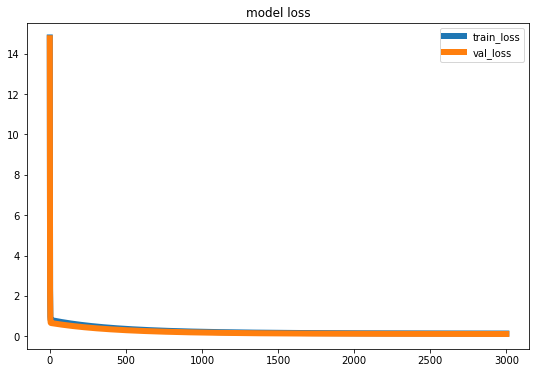

In [750]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_title("model loss")
ax.plot(np.arange(len(lr.loss)),lr.loss,label="train_loss",linewidth=6)
ax.plot(np.arange(len(lr.val_loss)),lr.val_loss,label="val_loss",linewidth=6)
ax.legend()
plt.show()